In [1]:
!pip install pandas

You should consider upgrading via the '/opt/sagemath-9.2/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
%display typeset

Calculando dX/dt:

In [3]:
var('X mu D t')
X = function('X')(t)
dxdt = diff(X,t) == mu*X-D*X
dxdt

diff(X(t), t) == -D*X(t) + mu*X(t)

Calculando dS/dt:

In [4]:
var('S mu D Sf X Y t')
S = function('S')(t)
dsdt = diff(S,t) == D*Sf - D*S -(mu*X/Y)
dsdt

diff(S(t), t) == D*Sf - D*S(t) - X*mu/Y

Desenvolvendo a matriz jacobiana:

In [5]:
var('S X mu D Y Sf x s')
J = jacobian([mu*x-D*x, D*Sf - D*s -(mu*x/Y)],[x,s])
J

[-D + mu       0]
[  -mu/Y      -D]

Calculando o traço (p):

In [8]:
J.trace()

-2*D + mu

Calculando o determinante (q):

In [9]:
J.det()

(D - mu)*D

p = -2D+mu

q = D^2 - muD

Δ=p^2-4*q

p^2 = (mu-2D)^2 = mu^2 -4muD +4D^2

4q = 4(D^2 - muD) = 4D^2 - 4muD

Δ = mu^2 -4muD +4D^2 - (4D^2 - 4muD) = mu^2

Autovetores:

In [10]:
J.eigenvectors_right()

[(-D + mu, [(1, -1/Y)], 1), (-D, [(0, 1)], 1)]

Autovalores:

In [11]:
J.eigenvalues()

[-D + mu, -D]

$\lambda_1$: -D

$\lambda_2$: -D+mu

Os autovalores são reais e distintos, já que mu > 0 (mu é taxa de crescimento específica; 1/Tempo): 

Se mu>D, os sinais dos autovalores são opostos ($\lambda_1$<0<$\lambda_2$): Equilíbrio instável em ponto de sela 

Se mu<D, os sinais dos autovalores são iguais, nesse caso negativos, já que D é taxa de diluição e portanto não pode ser negativo ($\lambda_1$<$\lambda_2$<0): Equilíbrio pontual estável

Se mu=D, um dos autovalores será 0. Nesse caso o modelo ficará constante, como pode ser visto mais adiante no notebook.

Note que mu-D será sempre maior que -D, logo mu-D será o autovalor dominante $(\lambda_d)$

Polinômio característico:

In [13]:
J.characteristic_polynomial()

x^2 + (2*D - mu)*x + D^2 - D*mu

In [14]:
J.characteristic_polynomial().roots()

[(-D + mu, 1), (-D, 1)]

In [15]:
J.jordan_form()

[-D + mu|      0]
[-------+-------]
[      0|     -D]

Calculando o equilíbrio pontual do sistema:

In [16]:
var('S X mu D Y Sf x s')
xdot(x,s) = mu*x-D*x
sdot(x,s) = D*Sf - D*s -(mu*x/Y)
solve([xdot, sdot], [x,s])

[[x == 0, s == Sf]]

In [17]:
dxdt = mu*X-D*X
dsdt = D*Sf - D*S -(mu*X/Y)

solve([dxdt,dsdt], [X,S])

[[X == 0, S == Sf]]

*-----------------------------------------------------------------------------------------------------*

In [18]:
var('x s mu D Sf X S mumax Ks')

mu==mumax*s/(Ks + s)

X = function('X')(t)
S = function('S')(t)
de1 = diff(X,t) == mu*X - D*X
de2 = diff(S,t) == D*Sf - D*S -(mu*X/Y)
sol = desolve_system([de1,de2],[X,S],ics=[0,0,0], ivar=t)
show(sol)

[X(t) == 0, S(t) == -Sf*e^(-D*t) + Sf]

Legenda: 


Azul==X (Concentração celular)

Verde==S (Concentração de substrato)

As equações de soluções de estado estacionário são as seguintes:

S = KsD/(mumax-D)

X = Y(Sf- KsD/(mumax-D))

mu = mumax.S/(Ks+S)

Parâmetros iniciais a seguir e modelagem foram retiradas do artigo 'Analytical solution for a hybrid Logistic-Monod cell growth model in batch and continuous stirred tank reactor culture. Peng Xu, 2019. (https://doi.org/10.1002/bit.27230)

In [27]:
mumax = 1.6
Ks = 1.0
Y = 0.8
Sf = 20.0
D = 1.0

In [28]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [29]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

14.6666666666667


In [30]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


Iniciando a simulação:

In [89]:
def model(t, y, params):
    X, S = y
    D, Sf, Y, mumax, Ks = params
    return [
        (mumax*S/(Ks+S))*X - D*X, #dX/dt
        D*Sf - D*S -((mumax*S/(Ks+S))*X/Y) # dS/dt
    ]

Fazendo a integração numérica:

In [91]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [106]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [107]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05487971, 11.7952635 ],
       [ 0.06043154, 13.26315512],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

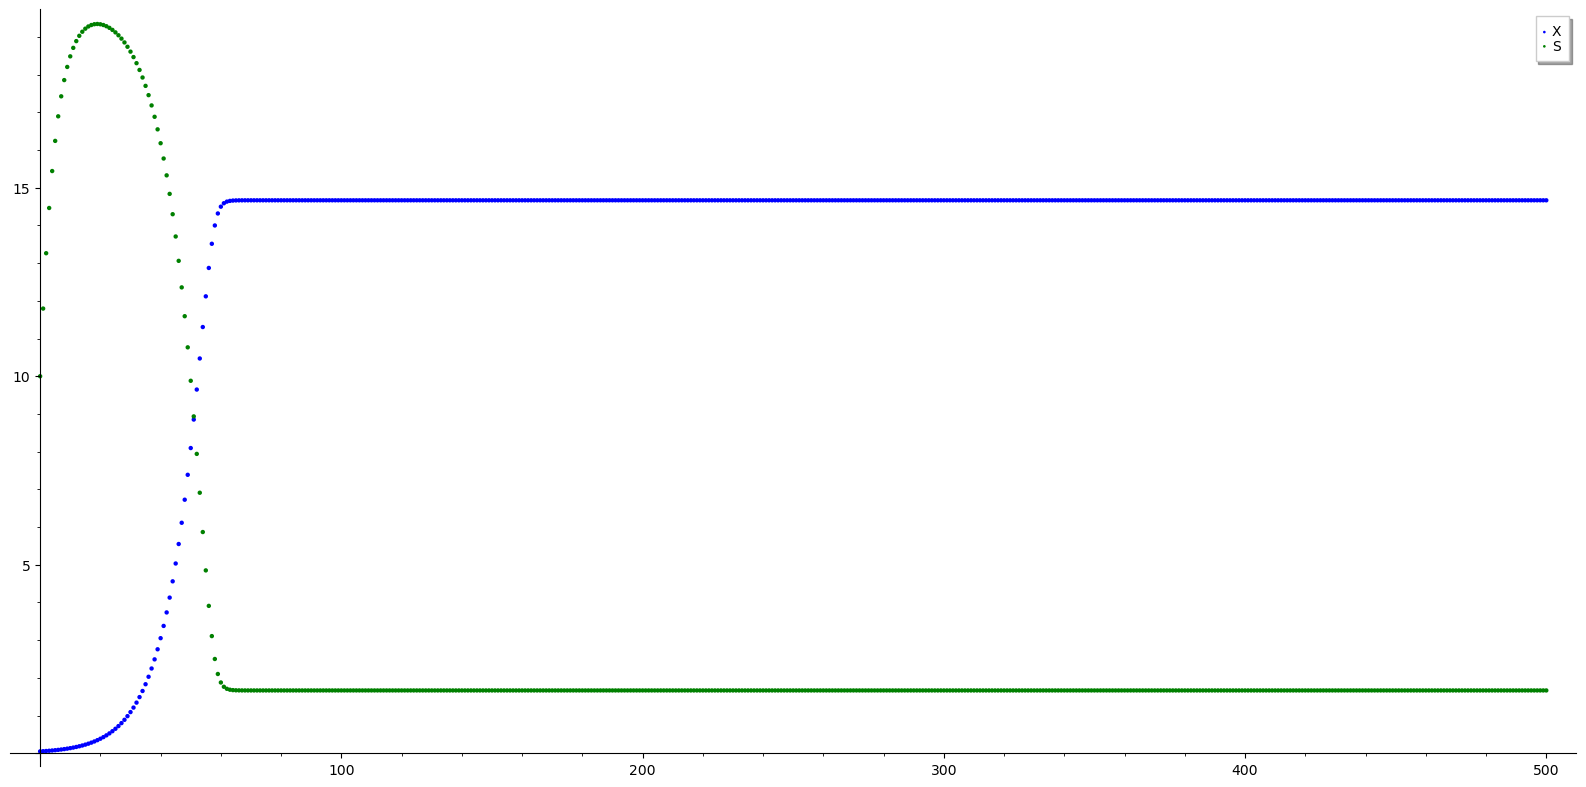

In [108]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [167]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

Alterando o limite de concentraçao de saída do substrato, de 10 para 2:

In [171]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 2.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [172]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      ,  2.        ],
       [ 0.05248973,  5.24840496],
       [ 0.05672379,  7.90522943],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

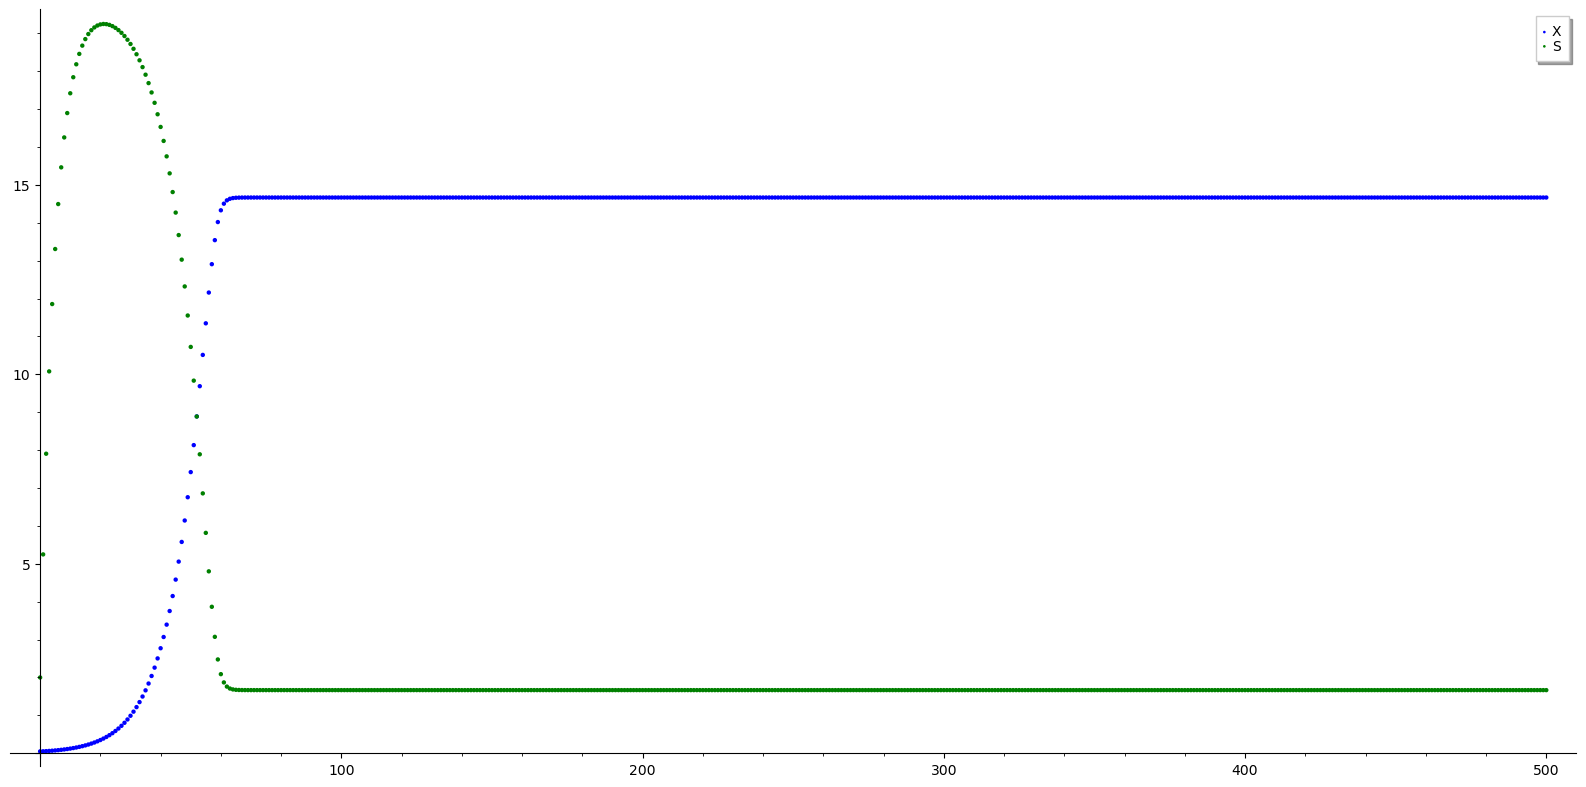

In [173]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Alterando o Coeficiente de Rendimento (Y) de 0.8 para 0.3:

In [102]:
mumax = 1.6   
Ks = 1.00     
Y = 0.3     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [113]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [114]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05487971, 11.7952635 ],
       [ 0.06043154, 13.26315512],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

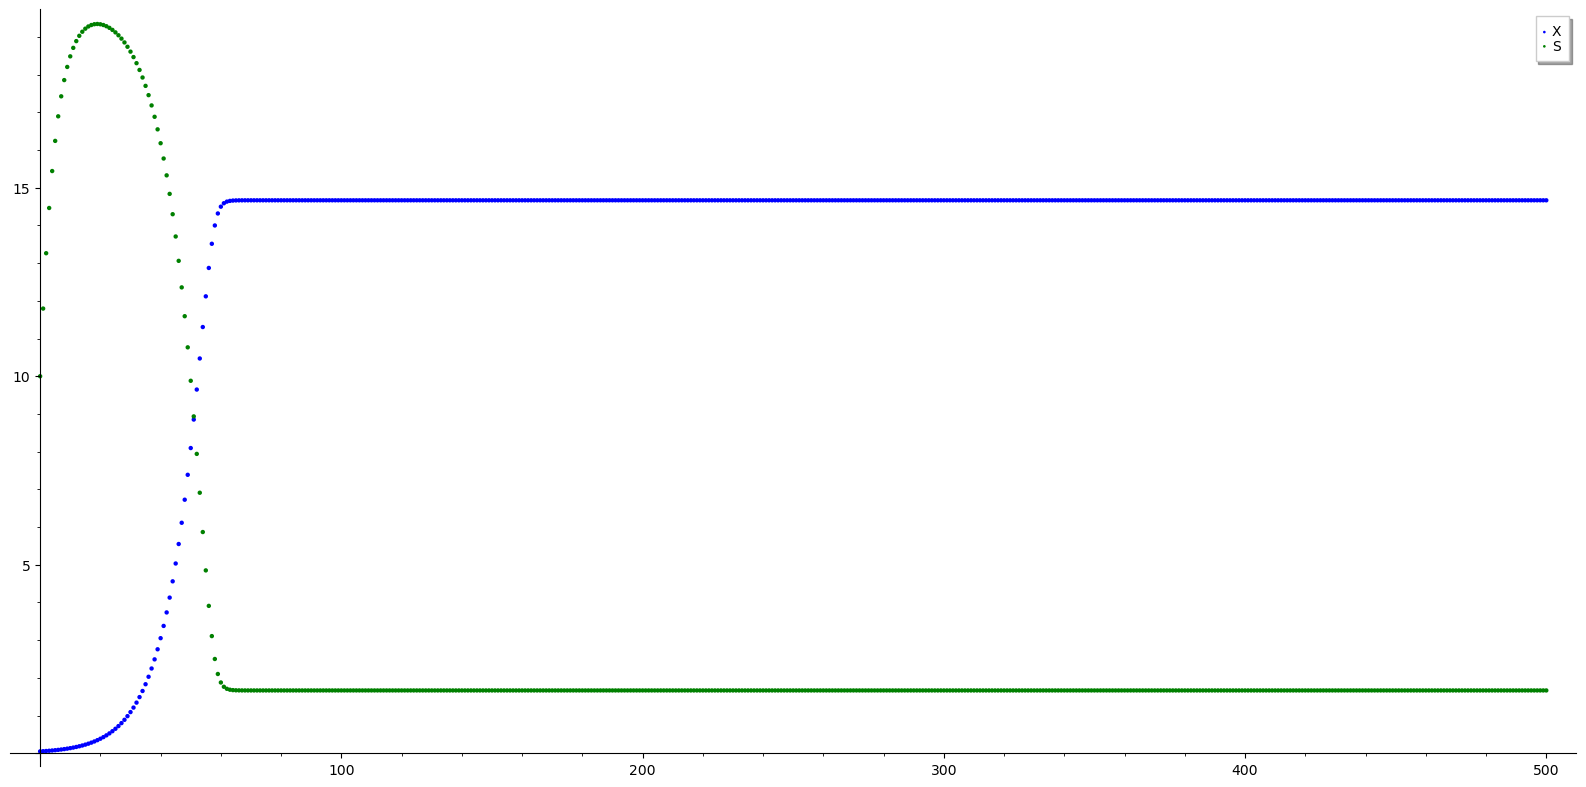

In [115]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Alterando o limite de concentraçao de saída do substrato, de 10 para 2:

In [116]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 2.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [117]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      ,  2.        ],
       [ 0.05248973,  5.24840496],
       [ 0.05672379,  7.90522943],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

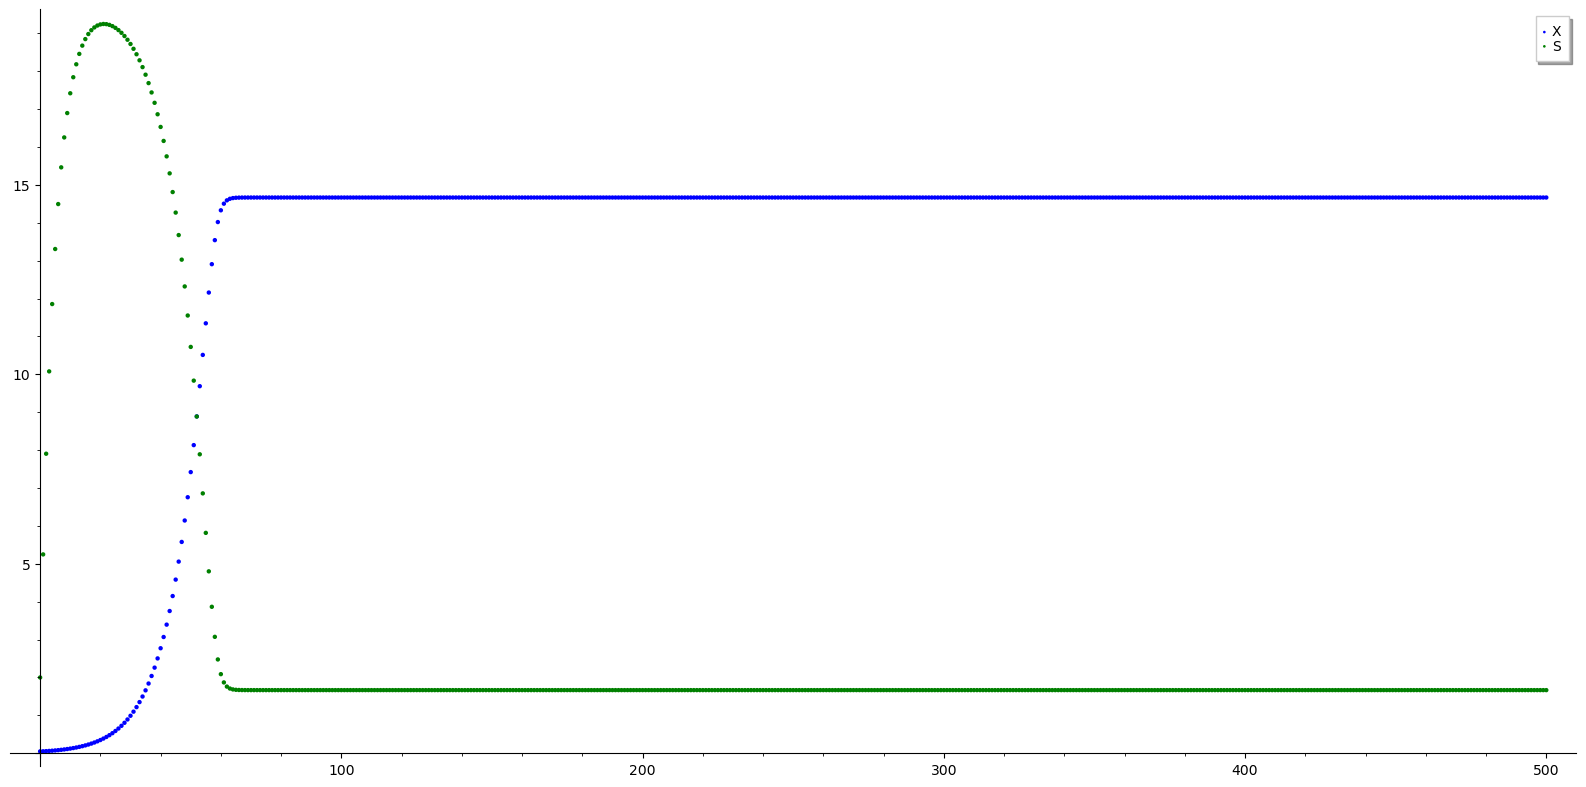

In [118]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Duplicando a Máxima Taxa de Crescimento Específica (mumax):

In [119]:
mumax = 3.2
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [126]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [127]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.07356861, 11.77190238],
       [ 0.10894173, 13.20251737],
       ...,
       [15.63636364,  0.45454545],
       [15.63636364,  0.45454545],
       [15.63636364,  0.45454545]])

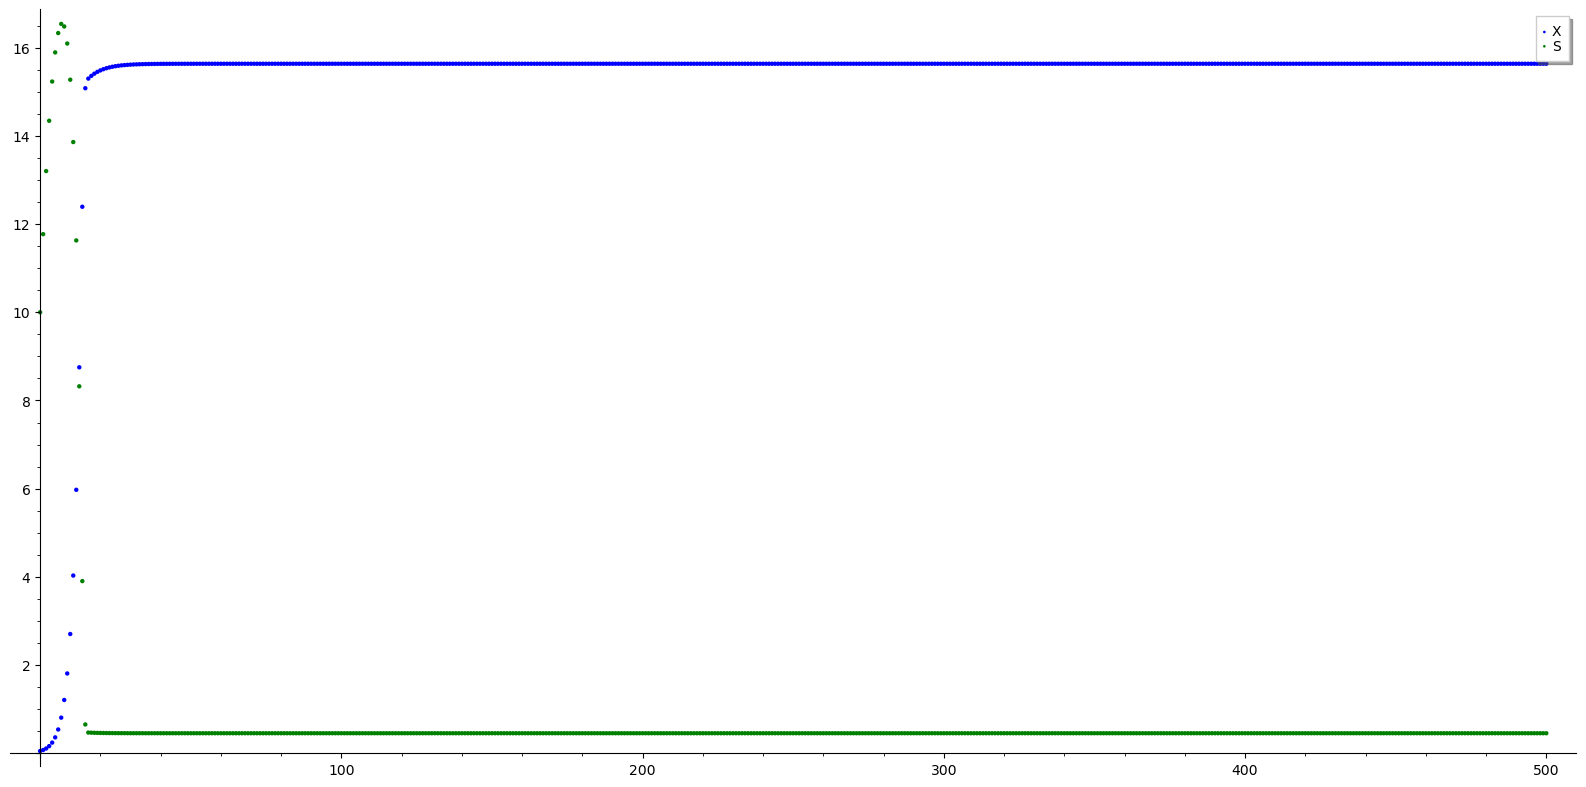

In [128]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Duplicando a concentração de massa celular inicial (X):

In [129]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [130]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.1, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [131]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.1       , 10.        ],
       [ 0.10975734, 11.77783714],
       [ 0.12085542, 13.22952027],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

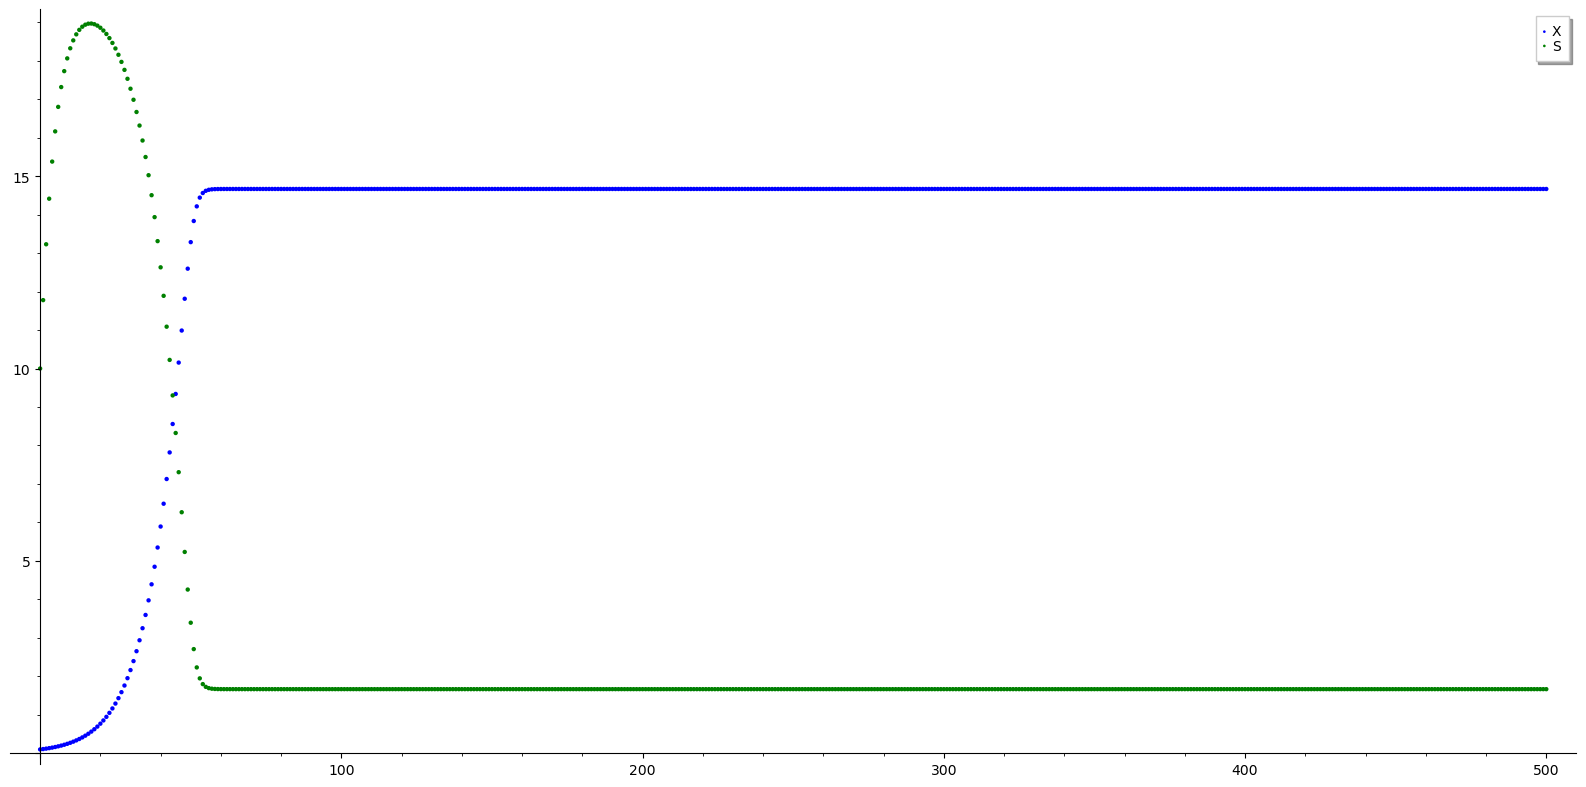

In [133]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dividindo a concentração de massa celular inicial (X) pela metade:

In [134]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.025, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [135]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.025     , 10.        ],
       [ 0.02744012, 11.80397766],
       [ 0.03021672, 13.27997614],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

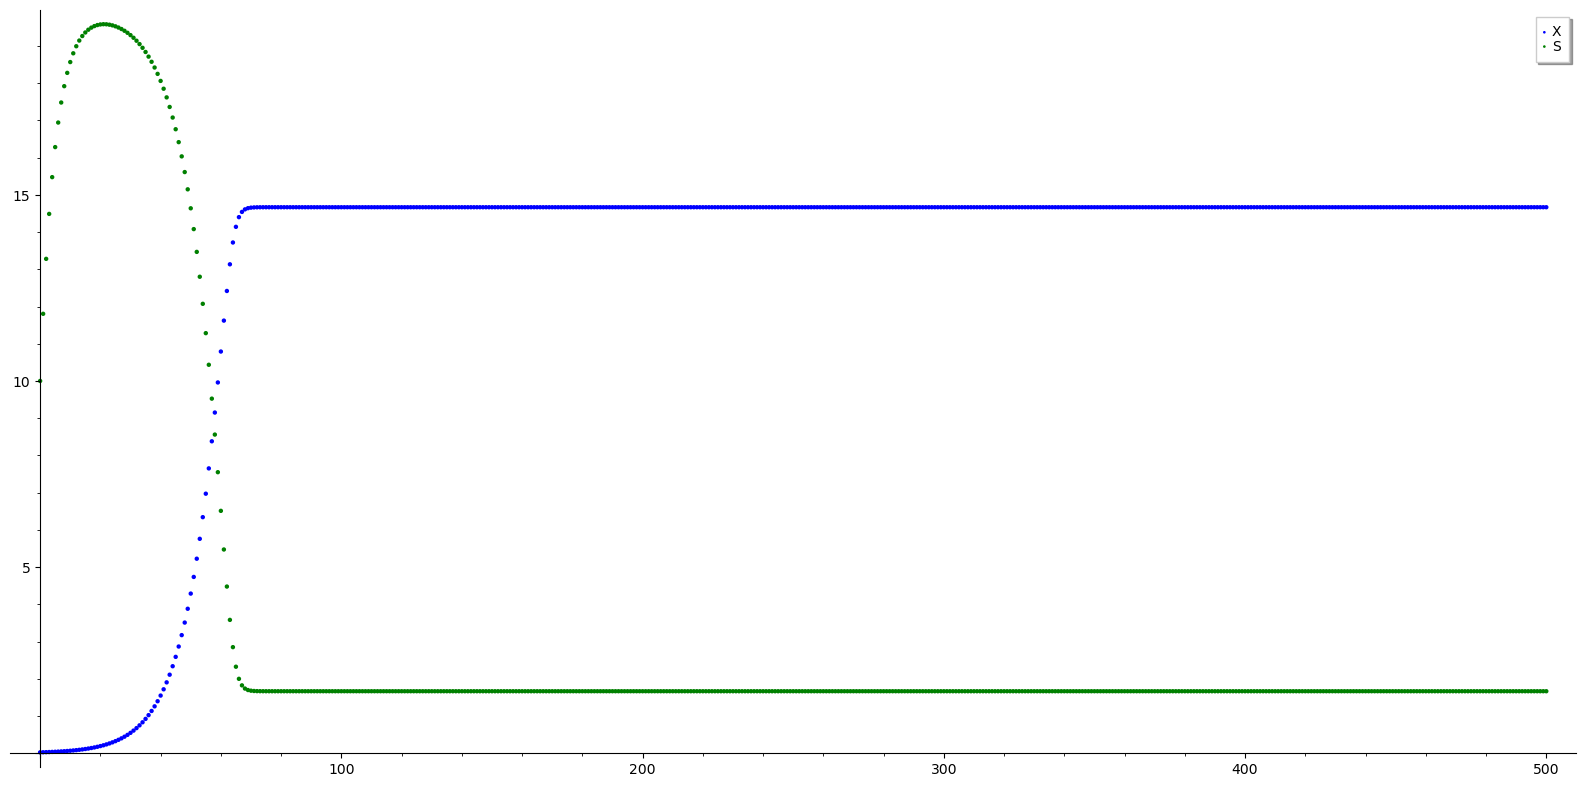

In [136]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Duplicando o limite de concentração de saída do substrato (S):

In [137]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 20.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [138]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 20.        ],
       [ 0.05552194, 19.98176825],
       [ 0.06165292, 19.96482885],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

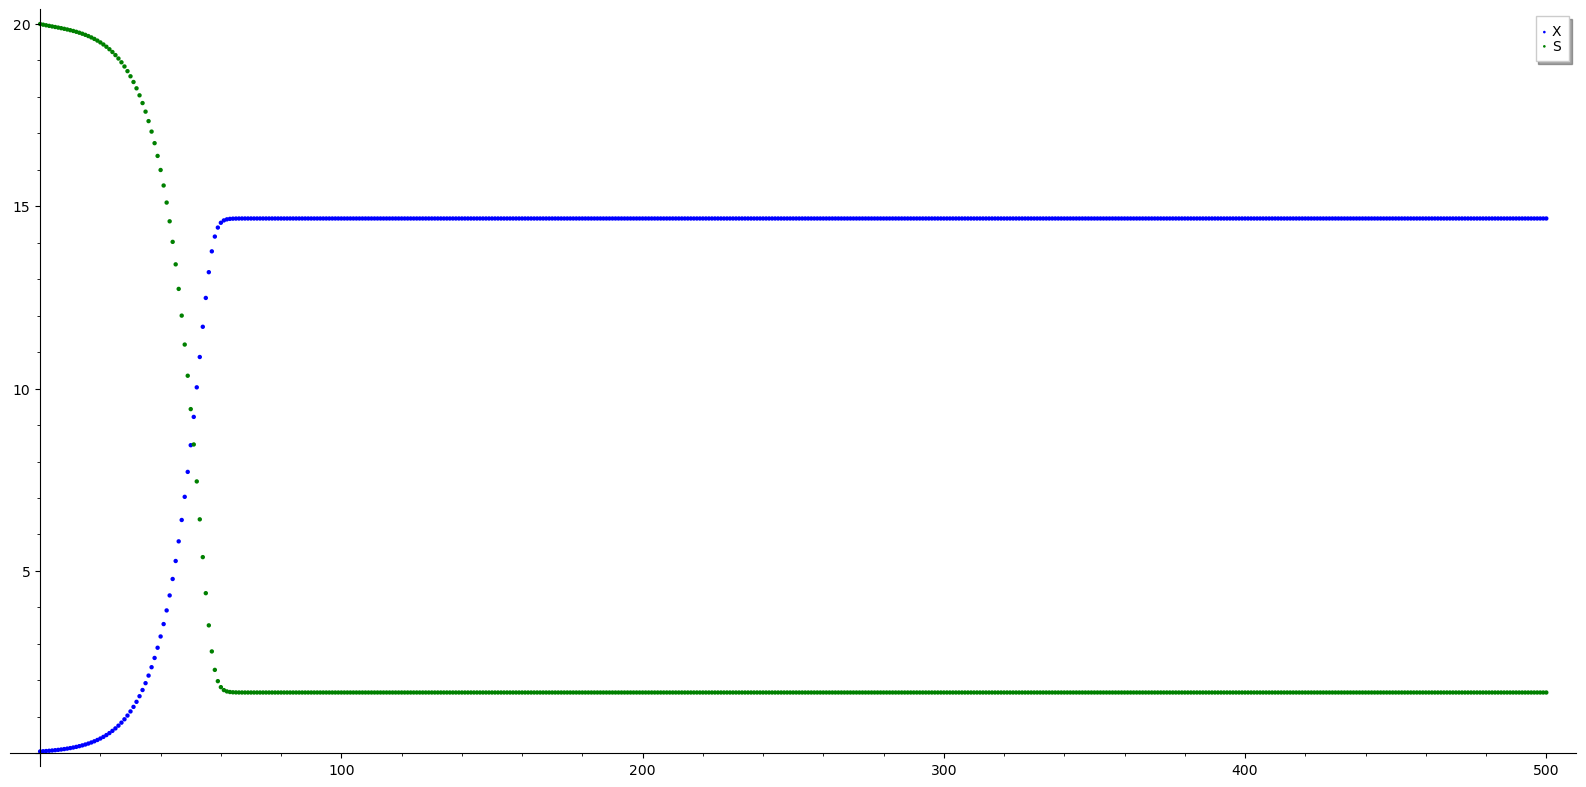

In [139]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dividinndo o limite de concentração de saída do substrato (S) pela metade:

In [140]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 5.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [141]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      ,  5.        ],
       [ 0.0539612 ,  7.70275788],
       [ 0.0588872 ,  9.91348532],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

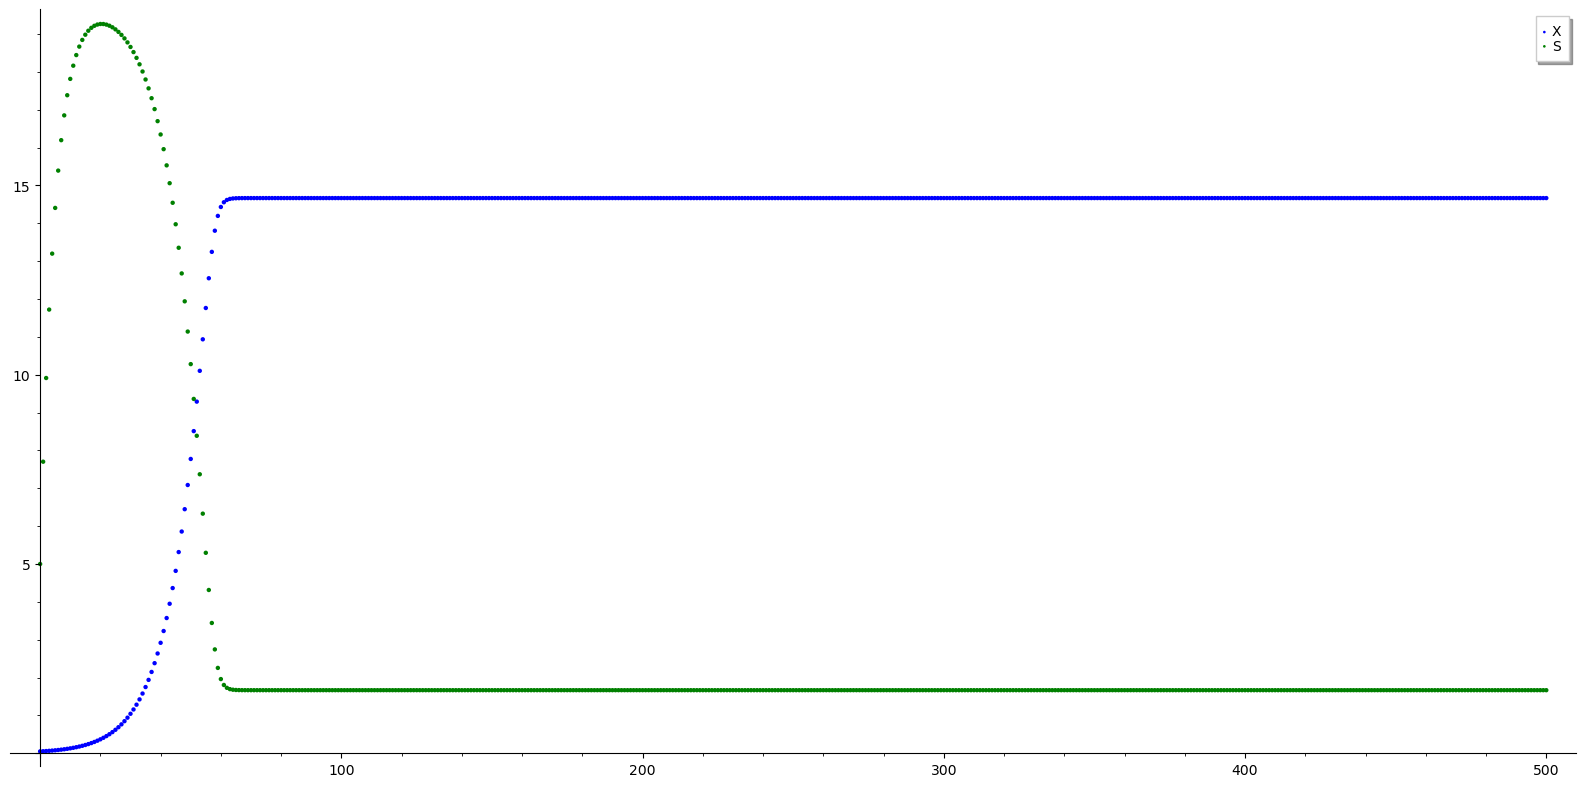

In [142]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Modelando como na Aula 1:

In [151]:
def ODEsys(t,y,params):
    mumax, Ks, D, Y, Sf = params
    X,S = y
    return[(mumax*S/(Ks+S))*X - D*X, #dX/dt
        D*Sf - D*S -((mumax*S/(Ks+S))*X/Y) # dS/dt
          ]

In [152]:
T=ode_solver()
T.algorithm="rk8pd"
T.function=ODEsys
T.ode_solve(y_0=[0.5,10.0],t_span=[0,50],params=[1.6, 1.0, 1.0, 0.8, 20.0],num_points=200)

In [153]:
T.solution[:10]

[(0, [0.500000000000000, 10.0000000000000]),
 (0.25, [0.5618952721750273, 11.996373568486797]),
 (0.5, [0.6341506672754752, 13.52108673109972]),
 (0.75, [0.7175394213438134, 14.674639291373325]),
 (1.0, [0.813233180643823, 15.53458876321311]),
 (1.25, [0.9226937863419092, 16.160650296508518]),
 (1.5, [1.0476442742552134, 16.59859940578965]),
 (1.75, [1.1900693446026933, 16.8832825993989]),
 (2.0, [1.352228995847822, 17.040945474847156]),
 (2.25, [1.5366787748013386, 17.09103380123101])]

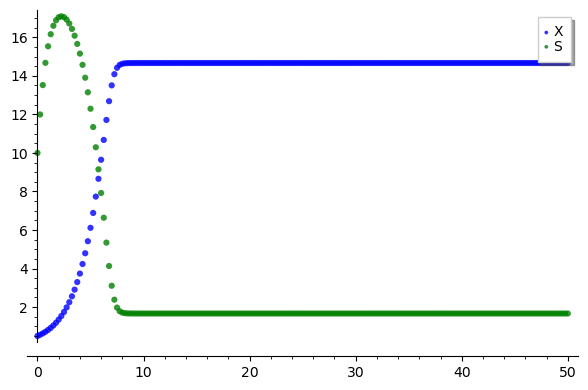

In [154]:
x=list_plot([(i[0],i[1][0]) for i in T.solution],color='blue', pointsize=20, legend_label='X', alpha=.8)
s=list_plot([(i[0],i[1][1]) for i in T.solution],color='green', pointsize=20, legend_label='S', alpha=.8)
x.legend()
s.legend()
show(x+s)

Encontrando a solução analítica:

In [163]:
var('t mumax Ks D Y Sf')

X = function('X')(t)
S = function('S')(t)
de1 = diff(X,t) == (mumax*S/(Ks + S))*X-D*X
de2 = diff(S,t) == D*Sf-D*S-((mumax*S/(Ks + S))*X/Y)
sol = desolve_system([de1,de2],[X,S],ics=[0,0.05,10.0], ivar=t)
show(sol)

[X(t) == ilt(1/20*(20*mumax*laplace(S(t)*X(t)/(Ks + S(t)), t, g4843) + 1)/(D + g4843), g4843, t),
 S(t) == ilt((D*Sf*Y - (mumax*laplace(S(t)*X(t)/(Ks + S(t)), t, g4843) - 10*Y)*g4843)/(D*Y*g4843 + Y*g4843^2), g4843, t)]

In [164]:
# Atribuindo  valores para as taxas de conversão:
solX, solS = sol[0].rhs(), sol[1].rhs()
plot((solX(mumax=1.6, Ks=1.0, D=1.0, Y=0.8, Sf=20.0),solS(mumax=1.6, Ks=1.0, D=1.0, Y=0.8, Sf=20.0)),(t,0,30))

ValueError: Variable 'g4843' not found